In [28]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt

In [6]:
# PostgreSQL connection configuration
conn = psycopg2.connect(
    "dbname='Bitcoin' user='postgres' host='localhost' password='root'"
)

In [7]:
# Function to fetch data from PostgreSQL database
def fetch_data():
    try:
        cur = conn.cursor()
        cur.execute("SELECT * FROM public.bitcoin_data ORDER BY event_time ASC")
        rows = cur.fetchall()
        columns = [desc[0] for desc in cur.description]
        df = pd.DataFrame(rows, columns=columns)
        return df
    except Exception as e:
        print("Error fetching data:", e)
        conn.rollback()  # Rollback the transaction in case of error
        return None

# Load data
df = fetch_data()

In [8]:
# Preprocess data
# Drop irrelevant columns
df = df[['event_time', 'open_price', 'high_price', 'low_price', 'base_asset_volume', 'number_of_trades', 'close_price']]
# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])
# Set event_time as index
df.set_index('event_time', inplace=True)

In [9]:
# Normalize data
scaler = MinMaxScaler()
df['close_price_scaled'] = scaler.fit_transform(df[['close_price']])

In [10]:
# Function to create input-output pairs using the window method
def create_window_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        X.append(window)
        y.append(data.iloc[i + window_size])  # Use iloc for indexing
    return np.array(X), np.array(y)


In [11]:
# Choose the window size (number of past time steps to consider)
window_size = 10


In [12]:
# Create input-output pairs using the window method
X, y = create_window_data(df['close_price_scaled'], window_size)

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [14]:
from keras.layers import Input

# Define input shape
input_shape = (window_size, 1)

# Build LSTM model
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [15]:
# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0756 - val_loss: 0.0032
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5.4845e-04 - val_loss: 7.8209e-04
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5699e-04 - val_loss: 7.1677e-04
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.7919e-04 - val_loss: 7.9609e-04
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.8991e-04 - val_loss: 6.7017e-04
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.9186e-04 - val_loss: 7.0149e-04
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.7902e-04 - val_loss: 6.5641e-04
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.7531e-04 - val_loss: 7.2779e-04
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5137e-04 - val_loss: 7.5223e-04
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6369e-04 - val_loss: 6.3628e-04
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10

In [26]:
# Save the model in the new Keras format
model.save('bitcoin_price_model.keras')

In [30]:
# Save the scaler along with the model
scaler_filename = 'bitcoin_price_scaler.pkl'
import pickle
pickle.dump(scaler, open(scaler_filename, 'wb'))

In [17]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3192e-04
Test Loss: 0.00023343383509200066


In [18]:
# Make predictions
y_pred = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [19]:
# Inverse transform the predictions to the original scale
y_pred_original_scale = scaler.inverse_transform(y_pred)

In [20]:
# Print first 5 predictions
print("Predictions (First 5) in Original Scale:", y_pred_original_scale[:5])

Predictions (First 5) in Original Scale: [[69101.1  ]
 [69101.125]
 [69101.16 ]
 [69101.18 ]
 [69101.195]]


In [21]:
# Inverse transform y_test to the original scale
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate absolute differences
absolute_diff = np.abs(y_test_original_scale.flatten() - y_pred_original_scale.flatten())

# Calculate percentage differences
percentage_diff = (absolute_diff / y_test_original_scale.flatten()) * 100

# Print differences for the first 5 predictions
print("Difference between Actual and Predicted Closing Prices:")
for i in range(5):
    print(f"Time Step {i+1}:")
    print(f"  Actual: {y_test_original_scale[i][0]}, Predicted: {y_pred_original_scale[i][0]}")
    print(f"  Absolute Difference: {absolute_diff[i]}")
    print(f"  Percentage Difference: {percentage_diff[i]}%\n")


Difference between Actual and Predicted Closing Prices:
Time Step 1:
  Actual: 69100.0, Predicted: 69101.1015625
  Absolute Difference: 1.1015625
  Percentage Difference: 0.001594157018813314%

Time Step 2:
  Actual: 69099.99, Predicted: 69101.125
  Absolute Difference: 1.1349999999947613
  Percentage Difference: 0.0016425472709833404%

Time Step 3:
  Actual: 69099.99, Predicted: 69101.15625
  Absolute Difference: 1.1662499999947613
  Percentage Difference: 0.0016877715901185532%

Time Step 4:
  Actual: 69100.0, Predicted: 69101.1796875
  Absolute Difference: 1.1796875
  Percentage Difference: 0.0017072178002894354%

Time Step 5:
  Actual: 69100.0, Predicted: 69101.1953125
  Absolute Difference: 1.1953125
  Percentage Difference: 0.0017298299565846598%



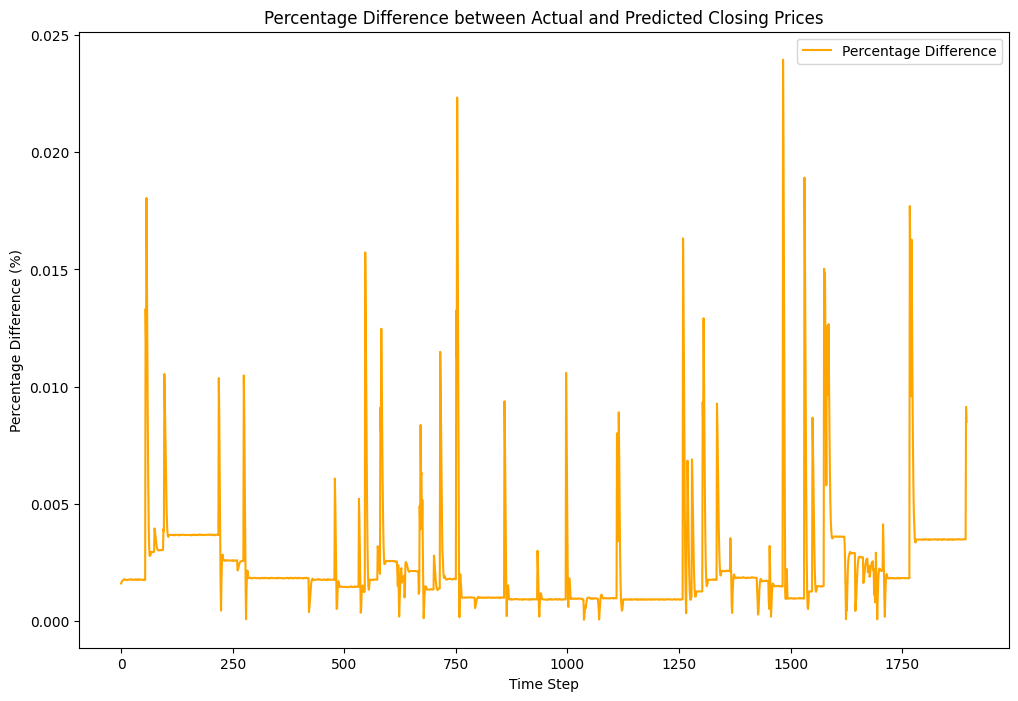

In [29]:
# Plot actual vs. predicted closing prices
plt.figure(figsize=(12, 8))

# Plot actual closing prices
plt.plot(y_test_original_scale, label='Actual', color='blue')

# Plot predicted closing prices
plt.plot(y_pred_original_scale, label='Predicted', color='red')

plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Plot absolute differences
plt.figure(figsize=(12, 8))
plt.plot(absolute_diff, label='Absolute Difference', color='green')
plt.title('Absolute Difference between Actual and Predicted Closing Prices')
plt.xlabel('Time Step')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

# Plot percentage differences
plt.figure(figsize=(12, 8))
plt.plot(percentage_diff, label='Percentage Difference', color='orange')
plt.title('Percentage Difference between Actual and Predicted Closing Prices')
plt.xlabel('Time Step')
plt.ylabel('Percentage Difference (%)')
plt.legend()
plt.show()
